In [2]:
!pip install hopsworks --quiet

In [3]:
    import hopsworks
    import pandas as pd
    from sklearn.ensemble import HistGradientBoostingClassifier
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib
    import os

In [4]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/199829
Connected. Call `.close()` to terminate connection gracefully.


In [5]:
# Create feature view with all features except for fixed_acidity
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select(["quality","type","volatile_acidity","citric_acid","residual_sugar","chlorides","free_sulfur_dioxide","total_sulfur_dioxide","density","ph","sulphates","alcohol"])

#Transform the categorical to value
label_encoder = fs.get_transformation_function(name="label_encoder")
transformation_functions = {"type": label_encoder}

feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from wine dataset",
                                  labels=["quality"],
                                  query=query,
                                  transformation_functions=transformation_functions)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/199829/fs/199748/fv/wine/version/1


In [6]:
# Read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (7.93s) 


KNeighborsClassifier(n_neighbors=2)

In [138]:
# Train our model with the Scikit-learn hitogram gradinet boosting classifier using our features (X_train) and labels (y_train)

model = HistGradientBoostingClassifier(l2_regularization=3, max_iter=75, learning_rate=0.2)
model.fit(X_train, y_train.values.ravel())

HistGradientBoostingClassifier(l2_regularization=3, learning_rate=0.2,
                               max_iter=75)

In [139]:
X_train

,type,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
0,0,0.735,0.10,2.1,0.079,6.0,31.0,0.99860,3.23,0.56,10.1
1,1,0.130,0.29,5.3,0.051,31.0,122.0,0.99440,3.44,0.37,9.7
2,1,0.210,0.25,1.1,0.035,26.0,81.0,0.99020,3.31,0.52,11.4
3,1,0.220,0.24,4.6,0.044,39.0,159.0,0.99270,2.99,0.28,11.5
5,0,0.690,0.32,2.5,0.088,22.0,91.0,0.99790,3.29,0.62,10.1
...,...,...,...,...,...,...,...,...,...,...,...
5288,0,0.180,0.37,0.9,0.049,36.0,109.0,0.99007,2.89,0.44,12.7
5289,1,0.270,0.42,2.6,0.044,29.0,110.0,0.99120,3.31,0.51,12.7
5291,1,0.220,0.34,5.0,0.032,36.0,93.0,0.99012,3.27,0.36,13.5
5292,0,0.310,0.46,1.4,0.059,11.0,25.0,0.99660,3.36,0.76,10.1


In [140]:
y_train

,quality
0,6
1,6
2,6
3,6
5,5
...,...
5288,6
5289,6
5291,7
5292,6


In [141]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [142]:
print(metrics)
print(metrics["accuracy"])

{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 8}, '4': {'precision': 0.3333333333333333, 'recall': 0.075, 'f1-score': 0.12244897959183673, 'support': 40}, '5': {'precision': 0.6203966005665722, 'recall': 0.6257142857142857, 'f1-score': 0.6230440967283073, 'support': 350}, '6': {'precision': 0.5607142857142857, 'recall': 0.6916299559471366, 'f1-score': 0.6193293885601578, 'support': 454}, '7': {'precision': 0.5789473684210527, 'recall': 0.463855421686747, 'f1-score': 0.5150501672240803, 'support': 166}, '8': {'precision': 0.5, 'recall': 0.05128205128205128, 'f1-score': 0.09302325581395347, 'support': 39}, '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, 'accuracy': 0.5807365439093485, 'macro avg': {'precision': 0.3704845125764634, 'recall': 0.2724973878043172, 'f1-score': 0.2818422697026194, 'support': 1059}, 'weighted avg': {'precision': 0.5671781797958584, 'recall': 0.5807365439093485, 'f1-score': 0.5602126252887952, 'support': 1059}}
0.5807

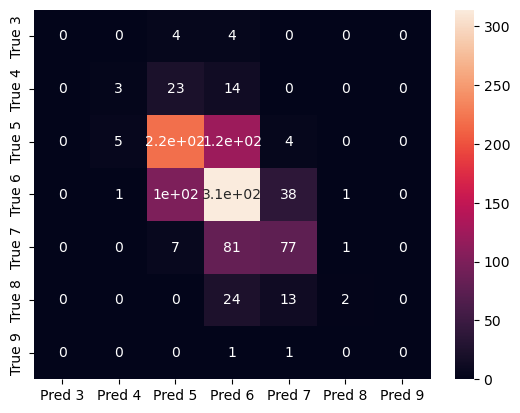

In [143]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ["True 3", "True 4", "True 5", "True 6", "True 7", "True 8", "True 9"],
                    ["Pred 3", "Pred 4", "Pred 5", "Pred 6", "Pred 7", "Pred 8", "Pred 9"],)
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

### Comments
Pretty much all guesses are centered around 5 and 6 which makes sense since that is where most data is. There is an option too put weight on specific classes when training the model but as we don't care about minorities but want the highest accuracy I have chosen not to do this.


In [144]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'wine_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor",
    version=1
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/27724 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1535312 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/990 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/199829/models/wine_model/1


Model(name: 'wine_model', version: 1)